# Import the neccessary libraries and files

In [1]:
#Data libraries
import shelve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, ifftshift
from scipy.optimize import minimize
import scipy.interpolate as si

In [ ]:
#Machine learning libraries
import torch
import torch.nn as nn
from torchvision import datasets ,transforms
import torchvision
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [2]:
from tools.ramanflow.read_data import ReadData 
from tools.ramanflow.prep_data import PrepData

## Import Stefano's functions

In [ ]:
res = 1600
num_th = 5
peak_pos = []
interpol_mse = []
slide_win = 100
nu = 0.01
interpol_mse = interpol_mse + [1000, 1000, 1000]

In [ ]:
def recursive_merge(inter, start_index = 0):
    for i in range(start_index, len(inter) - 1):
        if inter[i][1] > inter[i+1][0]:
            new_start = inter[i][0]
            new_end = inter[i+1][1]
            inter[i] = [new_start, new_end]
            del inter[i+1]
            return recursive_merge(inter.copy(), start_index=i)
    return inter 

In [ ]:
def spline_background_removal(x_data, y_data, res, num_th, slide_win)
    res = 1600
    num_th = 5
    peak_pos = []
    interpol_mse = []
    slide_win = 100
    nu = 0.01
    interpol_mse = interpol_mse + [1000, 1000, 1000]
    
    for j in range(num_th):
        # find the points that minimizes the variance of the data minus spline interpolation
        # scan all points, who cares
        idx_left=list(set(range(res)) - set(peak_pos))
        while True:
            plt.plot(x_data,y_data)
            plt.plot(x_data[idx_left],y_data[idx_left],'*')
        interpol_pos = []
        interpol_pos =  [0,np.argmin(y_data[idx_left]),res-1]
        #for i in range(int(y_data.shape[0]/slide_win)):
        for i in range(2*int(y_data.shape[0]/slide_win)):
            min_pos=0
            y_hat = si.interp1d(x_data[interpol_pos],y_data[interpol_pos])(x_data)
            min_mse=(1-nu)*np.dot((y_hat-y_data>0),np.abs((y_hat-y_data)))+nu*np.var(y_hat-y_data)
            tmp_interpol_pos=list(set(range(int(i*(slide_win/2)),min(int(i*(slide_win/2)+(slide_win)),res))) - set(peak_pos))
            for k in range(len(tmp_interpol_pos)):
                tmp_pos=np.concatenate((interpol_pos,[tmp_interpol_pos[k]]))
                y_hat = si.interp1d(x_data[tmp_pos],y_data[tmp_pos])(x_data)
                # generalize to any loss
                # tmp_mse=np.var(y_hat-y_data)
                tmp_mse=(1-nu)*np.dot((y_hat-y_data>0),np.abs((y_hat-y_data)))+nu*np.var(y_hat-y_data)
                # update the minimum
                if tmp_mse<min_mse:
                    min_pos = tmp_interpol_pos[k]
                    min_mse = tmp_mse
            interpol_pos.append(min_pos)
            #interpol_pos.sort()
            interpol_mse.append(min_mse)
            unique_pos=np.array([int(interpol_pos.index(x)) for x in set(interpol_pos)])
            interpol_pos=list(np.array(interpol_pos)[unique_pos.astype(int)])
            interpol_mse=list(np.array(interpol_mse)[unique_pos.astype(int)])
            # sort points
            sort_pos=np.argsort(interpol_pos)
            interpol_pos=list(np.array(interpol_pos)[sort_pos.astype(int)])
            interpol_mse=list(np.array(interpol_mse)[sort_pos.astype(int)])
            # remove points that are too close
        y_hat = si.interp1d(x_data[interpol_pos],y_data[interpol_pos])(x_data)
        y_bsp = np.poly1d(np.polyfit(x_data[interpol_pos], y_data[interpol_pos], 3) )(x_data)
        #y_bsp=si.interp1d(x_data[interpol_pos],y_data[interpol_pos], kind='cubic')(x_data)
        while True:
            plt.plot(x_data,y_data)
            plt.plot(x_data,y_hat)
            plt.plot(x_data,y_bsp)
        mean_level=y_bsp
        #--------------------------------------------------------------------
        #   find when you acre over the mean level
        #--------------------------------------------------------------------
        # th=2*np.sqrt(np.var(y_data-mean_level))
        th=np.sqrt(np.var(y_data-mean_level))
        pos=np.array(np.where((y_data-mean_level)<th)[0])
        while True:
            plt.plot(x_data,y_data)
            plt.plot(x_data,y_bsp)
            plt.plot(x_data[pos],y_bsp[pos],'*')
        #--------------------------------------------------------------------
        #   merge the points
        #--------------------------------------------------------------------
        diff_pos=pos[1:]-pos[:-1]-1
        jumps=np.where(diff_pos>0)[0]
        #if the final element is res, the add a jomp an the end
        if pos[-1]==res-1:
            jumps=np.append(jumps,pos.shape[0]-1)
        final_lb=[]
        final_rb=[]
        if jumps.size==0:
                final_lb.append(pos[0])
                final_rb.append(pos[-1])
        else:
                final_lb.append(pos[0])
                final_rb.append(pos[jumps[0]])
                k=0
                while k<jumps.shape[0]-1:
                    #
                    final_lb.append(pos[jumps[k]+1])
                    # go to the next gap
                    k=k+1
                    final_rb.append(pos[jumps[k]])
        # add the first and the last intervals
        idx_lr=np.zeros([2,len(final_rb)])
        idx_lr[0]=np.array(final_lb)
        idx_lr[1]=np.array(final_rb)
        idx_lr.astype(int)
        idx_lr=idx_lr.T
        # merge intervals
        # remove the one intervals
        idx_lr=idx_lr[np.where(idx_lr[:,1]-idx_lr[:,0]>2)[0],:]
        merged = recursive_merge(idx_lr.tolist())
        idx_lr = np.array(merged).astype(int)
        idx_lr_poly = idx_lr
    for j in range(num_th):
        # find the points that minimizes the variance of the data minus spline interpolation
        # scan all points, who cares
        idx_left=list(set(range(res)) - set(peak_pos))
        while False:
            plt.plot(x_data,y_data)
            plt.plot(x_data[idx_left],y_data[idx_left],'*')
        interpol_pos = []
        interpol_pos =  [0,np.argmin(y_data[idx_left]),res-1]
        #for i in range(int(y_data.shape[0]/slide_win)):
        for i in range(2*int(y_data.shape[0]/slide_win)):
            min_pos=0
            y_hat = si.interp1d(x_data[interpol_pos],y_data[interpol_pos])(x_data)
            min_mse=(1-nu)*np.dot((y_hat-y_data>0),np.abs((y_hat-y_data)))+nu*np.var(y_hat-y_data)
            tmp_interpol_pos=list(set(range(int(i*(slide_win/2)),min(int(i*(slide_win/2)+(slide_win)),res))) - set(peak_pos))
            for k in range(len(tmp_interpol_pos)):
                tmp_pos=np.concatenate((interpol_pos,[tmp_interpol_pos[k]]))
                y_hat = si.interp1d(x_data[tmp_pos],y_data[tmp_pos])(x_data)
                # generalize to any loss
                # tmp_mse=np.var(y_hat-y_data)
                tmp_mse=(1-nu)*np.dot((y_hat-y_data>0),np.abs((y_hat-y_data)))+nu*np.var(y_hat-y_data)
                # update the minimum
                if tmp_mse<min_mse:
                    min_pos = tmp_interpol_pos[k]
                    min_mse = tmp_mse
            interpol_pos.append(min_pos)
            #interpol_pos.sort()
            interpol_mse.append(min_mse)
            unique_pos=np.array([int(interpol_pos.index(x)) for x in set(interpol_pos)])
            interpol_pos=list(np.array(interpol_pos)[unique_pos.astype(int)])
            interpol_mse=list(np.array(interpol_mse)[unique_pos.astype(int)])
            # sort points
            sort_pos=np.argsort(interpol_pos)
            interpol_pos=list(np.array(interpol_pos)[sort_pos.astype(int)])
            interpol_mse=list(np.array(interpol_mse)[sort_pos.astype(int)])
            # remove points that are too close
        y_hat = si.interp1d(x_data[interpol_pos],y_data[interpol_pos])(x_data)
        y_bsp = np.poly1d(np.polyfit(x_data[interpol_pos], y_data[interpol_pos], 3) )(x_data)
        #y_bsp=si.interp1d(x_data[interpol_pos],y_data[interpol_pos], kind='cubic')(x_data)
        while True:
            plt.plot(x_data,y_data)
            plt.plot(x_data,y_hat)
            plt.plot(x_data,y_bsp)
        mean_level=y_bsp
        #--------------------------------------------------------------------
        #   find when you acre over the mean level
        #--------------------------------------------------------------------
        # th=2*np.sqrt(np.var(y_data-mean_level))
        th=np.sqrt(np.var(y_data-mean_level))
        pos=np.array(np.where((y_data-mean_level)<th)[0])
        while True:
            plt.plot(x_data,y_data)
            plt.plot(x_data,y_bsp)
            plt.plot(x_data[pos],y_bsp[pos],'*')
        #--------------------------------------------------------------------
        #   merge the points
        #--------------------------------------------------------------------
        diff_pos=pos[1:]-pos[:-1]-1
        jumps=np.where(diff_pos>0)[0]
        #if the final element is res, the add a jomp an the end
        if pos[-1]==res-1:
            jumps=np.append(jumps,pos.shape[0]-1)
        final_lb=[]
        final_rb=[]
        if jumps.size==0:
                final_lb.append(pos[0])
                final_rb.append(pos[-1])
        else:
                final_lb.append(pos[0])
                final_rb.append(pos[jumps[0]])
                k=0
                while k<jumps.shape[0]-1:
                    #
                    final_lb.append(pos[jumps[k]+1])
                    # go to the next gap
                    k=k+1
                    final_rb.append(pos[jumps[k]])
        # add the first and the last intervals
        idx_lr=np.zeros([2,len(final_rb)])
        idx_lr[0]=np.array(final_lb)
        idx_lr[1]=np.array(final_rb)
        idx_lr.astype(int)
        idx_lr=idx_lr.T
        # merge intervals
        # remove the one intervals
        idx_lr=idx_lr[np.where(idx_lr[:,1]-idx_lr[:,0]>2)[0],:]
        merged = recursive_merge(idx_lr.tolist())
        idx_lr = np.array(merged).astype(int)
        idx_lr_poly = idx_lr

In [ ]:
def remove_est_florescence(f_sup,data_sub):
    
    #min_data_amm=np.min(data_sub,axis=1)
    if data_sub.ndim>1:
        min_data_amm=np.mean(data_sub, axis = 0)
    else:
        min_data_amm=data_sub
    
    poly_min=np.poly1d(np.polyfit(f_sup,min_data_amm,3))(f_sup)
    poly_min_pos=poly_min+min(min_data_amm-poly_min)
    
    beta_init=np.polyfit(f_sup,min_data_amm,4)
    beta_init[4]=beta_init[4]+min(min_data_amm-poly_min)
    
    result = minimize(pos_mse_loss, beta_init, args=(f_sup,min_data_amm,poly4), method='Nelder-Mead', tol=1e-12)
#     result = minimize(mse_loss, beta_init, args=(f_sup,min_data_amm,poly4), method='Nelder-Mead', tol=1e-12)
#     result = minimize(reg_pos_mse_loss, beta_init, args=(f_sup,min_data_amm,poly4), method='Nelder-Mead', tol=1e-12)
    
    beta_hat = result.x                 
        
    plt_back=0
        
    if plt_back:
            plt.figure('Pos MSE fit')
            #plt.plot(f_sup,np.mean(data_sub,axis=1),'--',label='original data')    
            plt.plot(f_sup,min_data_amm,label='original data')    
            #plt.plot(f_sup,np.mean(data_sub,axis=1),'-.',label='data minus bias')
            plt.plot(f_sup,poly4(f_sup,beta_init),'-.',label='poly 4 init')
            plt.plot(f_sup,poly4(f_sup,beta_hat),'-.',label='poly 4 hat')
            plt.legend()
            
        
    # subtract mean
    
    if data_sub.ndim>1:
        data_sub2=np.subtract(data_sub,poly4(f_sup,beta_hat).reshape([data_sub.shape[0],1]))
    else:
        data_sub2=data_sub-poly4(f_sup,beta_hat)
            
    plt_final=0
    
    if plt_final:
        plt.figure('Final recap')        
        plt.plot(f_sup,poly4(f_sup,beta_hat),'--',label='poly 4 hat')
        plt.plot(f_sup,min_data_amm,label='original data-back')    
        if data_sub.ndim>1:
            plt.plot(f_sup,np.mean(data_sub2,axis=1),label='original data-back-pos_MSE')    
        else:
            plt.plot(f_sup,data_sub2,label='original data-back-pos_MSE')    
        
        plt.legend()
        
    return data_sub2

In [ ]:
def smooth_data(y_data,win):
    smooth=np.array([np.mean(y_data[int(np.max([j-win,0])):int(np.min([j+win,y_data.size]))]) for j in  range(y_data.shape[0])])
    return smooth

In [ ]:
def positive_mse(y_pred,y_true):                
    loss=np.dot((10**8*(y_pred-y_true>0)+np.ones(y_true.size)).T,(y_pred-y_true)**2)
    return sum(loss)/y_true.size

def pos_mse_loss(beta, X, Y,function):                
    return positive_mse(function(X,beta), Y)


def positive_mse_loss(beta, X, Y):
    p=np.poly1d(beta)
    error = sum([positive_mse(p(X[i]), Y[i]) for i in range(X.size)])/X.size
    return(error)

def reg_positive_mse(y_pred,y_true):                
    loss_pos=(y_pred-y_true)**2
    loss_neg=np.dot((y_pred-y_true<0),(y_pred-y_true)**8)
    loss=loss_pos+loss_neg
    return np.sum(loss)/y_true.size

def reg_pos_loss(beta, X, Y,function):                
    return positive_mse(function(X,beta), Y)


def mse_loss(beta,X, Y,function):
    return sum((function(X,beta)-Y)**2)/Y.size

def recursive_merge(inter, start_index = 0):
    for i in range(start_index, len(inter) - 1):
        if inter[i][1] > inter[i+1][0]:
            new_start = inter[i][0]
            new_end = inter[i+1][1]
            inter[i] = [new_start, new_end]
            del inter[i+1]
            return recursive_merge(inter.copy(), start_index=i)
    return inter    

def poly4(x_data,beta):
        p=np.poly1d(beta)
        return p(x_data)
        
def positive_mse(y_pred,y_true):                
    loss=np.dot((10**8*(y_pred-y_true>0)+np.ones(y_true.size)).T,(y_pred-y_true)**2)
    return np.sum(loss)/y_true.size

def pos_mse_loss(beta, X, Y,function):                
    return positive_mse(function(X,beta), Y)

def reg_positive_mse(y_pred,y_true):                
    loss_pos=(y_pred-y_true)**2
    loss_neg=np.dot((y_pred-y_true>0),np.abs((y_pred-y_true)))
    loss=loss_pos+loss_neg
    return np.sum(loss)/y_true.size

def reg_pos_mse_loss(beta, X, Y,function):                
    return reg_positive_mse(function(X,beta), Y)

# Import data

### Import pristine spectrum
Prisitine spectra will be regarded as spectrum of substrate itself without analytes


In [ ]:
pristine_area1 = pd.read_csv('area1_Exported.dat', sep="\s+", header=None)

length = pristine_area1.shape[1] - 1
f_sup_pristine = np.array(pristine_area1.iloc[:, 0], dtype=np.float64)
pristine_area1 = np.array(pristine_area1.iloc[:, 1], dtype=np.float64)

### Import MG of different concetrations
This type of import works in Jupyter, however doesn't work in Spyder or Pycharm

In [3]:
filename='shelve_save_data.out'

my_shelf = shelve.open(filename)
# klist = list(my_shelf.keys())
for key in my_shelf:
    globals()[key] = my_shelf[key]
my_shelf.close()
# print(klist)

In [4]:
#Save the wavelength variable 
f_sup_pure = np.copy(f_sup)
f_sup_pure.shape
# print(klist)

(1600,)

### Import mixed analytes

In [ ]:
filename='shelve_save_data_analyte.out'

my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [ ]:
#Save the wavelength variable for mixed
f_sup_mix = np.copy(f_sup)
f_sup_mix.shape

# Prepare data for different batches

#### Import MG from file to variable 
Then assign different slices to different conetrations. We also encode labels to one-hot vector and get rid of zero spectra

In [5]:
whole_data_pure = np.zeros((30000, 1600))
# print(whole_data.shape)
whole_data_pure[0:2500] = np.copy(data_15000[0])
whole_data_pure[2500:5000] = np.copy(data_15000[1])
whole_data_pure[5000:7500] = np.copy(data_15000[2])
whole_data_pure[7500:10000] = np.copy(data_15000[3])
whole_data_pure[10000:12500] = np.copy(data_1500[0])
whole_data_pure[12500:15000] = np.copy(data_1500[1])
whole_data_pure[15000:17500] = np.copy(data_1500[2])
whole_data_pure[17500:20000] = np.copy(data_1500[3])
whole_data_pure[20000:22500] = np.copy(data_150[0])
whole_data_pure[22500:25000] = np.copy(data_150[1])
whole_data_pure[25000:27500] = np.copy(data_150[2])
whole_data_pure[27500:30000] = np.copy(data_150[3])

One hot vector works for Keras, but for Stanford Pytorch model class labels should be converted to integers.  
`mask` variable is needed for eliminating empty spectra 

In [6]:
training_data = np.copy(whole_data_pure) / np.max(whole_data_pure, axis=-1, keepdims=True)
mask = np.all(np.isfinite(training_data), axis=-1)
# mask = np.all(training_data, axis=-1)
labels = np.zeros((30000, 3))
labels[:10000, 0] = 1
labels[10000:20000, 1] = 1
labels[20000:, 2] = 1
# Remove the following line if need to run in Keras
labels_not_one_hot = np.where(labels==1)[1]

<ipython-input-6-a1f3e35a00ac>:1: RuntimeWarning: invalid value encountered in true_divide
  training_data = np.copy(whole_data_pure) / np.max(whole_data_pure, axis=-1, keepdims=True)


In [ ]:
print(mask)

In [7]:
X = training_data[mask]
y = labels_not_one_hot[mask]
print(X.shape)
print(y.shape)

(25511, 1600)
(25511,)


# Data pretreatment 

### FFT and Bandpass approach

In [ ]:
signal_orig = np.zeros(2048,)

In [ ]:
signal_orig.shape

In [8]:
signal_orig = np.copy(X[6, :])

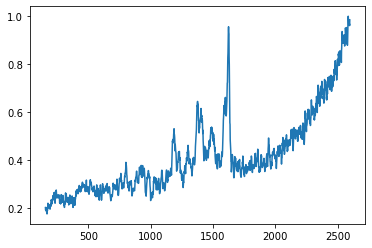

In [9]:
plt.plot(f_sup_pure, signal_orig)

In [ ]:
signal_orig_smooth = smooth_data(signal_orig, 5)

(1600,)

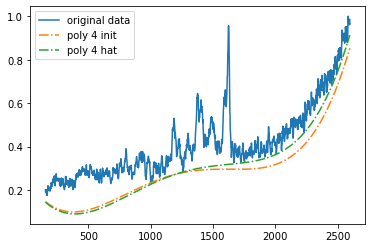

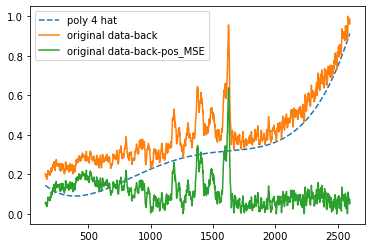

In [11]:
signal_ste_poly = PrepData.remove_est_florescence(f_sup_pure, signal_orig, 'pos-mse')
signal_ste_poly.shape

In [ ]:
plt.plot(f_sup_pure, signal_orig)
plt.plot(f_sup_pure, signal_ste_poly)

In [ ]:
plt.plot(f_sup_pure, (signal_orig_smooth-poly_interp)**2)

In [ ]:
signal_orig = np.copy(X)

In [ ]:
signal_ste_poly = np.zeros_like(signal_orig)
for i in range(signal_orig.shape[0]):
    signal_ste_poly[i, :] = remove_est_florescence(f_sup_pure, signal_orig[i, :])
    print(i)

In [ ]:
filename='shelve_save_data.out'
    
my_shelf = shelve.open(filename)

my_shelf["data_rm_fl"]=signal_ste_poly 

my_shelf.close()

In [ ]:
signal_ste_smooth = smooth_data(signal_ste_poly, 5)

In [ ]:
plt.plot(signal_ste_smooth)

#### Two ways of modifying signals  
1st Concatenate the mirrored signal to the end of the original signal  

2nd Zero pad so that the number of points in signal is a power of 2

In [ ]:
print(type(signal_orig))
print(type(np.flip(signal_orig)))
signal_orig_hstacked = np.hstack((signal_ste_poly, np.fliplr(signal_ste_poly)))

In [ ]:
signal_orig_hstacked = np.hstack((signal_orig, np.flip(signal_orig)))

In [ ]:
signal_orig_hstacked = np.hstack((signal_orig, np.fliplr(signal_orig)))

In [ ]:
plt.plot(signal_orig_hstacked)

In [ ]:
signal_spec = np.fft.fftshift(np.fft.fft(signal_orig_hstacked), axes=-1)

In [ ]:
# Trying something new 
signal_spec = np.fft.fft(signal_orig)

In [ ]:
plt.plot(signal_spec)

In [ ]:
signal_spec = np.fft.fft(signal_orig)
# print(signal_spec[0:16])

#### Apply highpass and lowpass filter to the FFT of the signal

In [ ]:
N = X.shape[-1]
print(N)
first_segment_hp = np.array(range(0, int(0.005*N)))
second_segment_hp = np.array(range(int(0.005*N), int(0.01*N)))
third_segment_hp = np.array(range(int(0.01*N), N))
first_segment_lp = np.array(range(0, int(0.25*N)))
second_segment_lp = np.array(range(int(0.25*N), int(0.5*N)))
third_segment_lp = np.array(range(int(0.5*N), N))

## Not concatenated

In [ ]:
# Highpass
signal_spec[first_segment_hp] = signal_spec[first_segment_hp] * ((first_segment_hp * 2) / N)
signal_spec[second_segment_hp] = signal_spec[second_segment_hp] * \
                                    (((second_segment_hp - 0.005 * N) / N) * (0.89/0.005))
signal_spec[third_segment_hp] = signal_spec[third_segment_hp]* \
                                     (((third_segment_hp - 0.01 * N) / N) * (0.1/0.99))

In [ ]:
# Lowpass 
signal_spec[first_segment_lp] = signal_spec[first_segment_lp] * (1 - (first_segment_lp * 0.1 / (0.25 * N)))
signal_spec[second_segment_lp] = signal_spec[second_segment_lp] * \
                                (1.7 - ((second_segment_lp * 0.8) / (0.25 * N)))
signal_spec[third_segment_lp] = signal_spec[third_segment_lp] * \
                                (0.2 - ((third_segment_lp * 0.1) / (0.5 * N)))

## Concatenated 

In [ ]:
# Highpass filtering
signal_spec[N + first_segment_hp] = signal_spec[N + first_segment_hp] * ((first_segment_hp * 2) / N)
signal_spec[N - first_segment_hp] = signal_spec[N - first_segment_hp] * ((first_segment_hp * 2) / N)
signal_spec[N + second_segment_hp] = signal_spec[N + second_segment_hp] * \
                                    (((second_segment_hp - 0.005 * N) / N) * (0.89/0.005))
signal_spec[N - second_segment_hp] = signal_spec[N - second_segment_hp] * \
                                    (((second_segment_hp - 0.005 * N) / N) * (0.89/0.005))
signal_spec[N + third_segment_hp] = signal_spec[N + third_segment_hp]* \
                                     (((third_segment_hp - 0.01 * N) / N) * (0.1/0.99))
signal_spec[N - third_segment_hp] = signal_spec[N - third_segment_hp] * \
                                    (((third_segment_hp - 0.01 * N) / N) * (0.1/0.99))

In [ ]:
# Lowpass filtering
signal_spec[N + first_segment_lp] = signal_spec[N + first_segment_lp] * (1 - (first_segment_lp * 0.1 / (0.25 * N)))
signal_spec[N - first_segment_lp] = signal_spec[N - first_segment_lp] * (1 - (first_segment_lp * 0.1 / (0.25 * N)))
signal_spec[N + second_segment_lp] = signal_spec[N + second_segment_lp] * \
                                (1.7 - ((second_segment_lp * 0.8) / (0.25 * N)))
signal_spec[N - second_segment_lp] = signal_spec[N - second_segment_lp] * \
                                (1.7 - ((second_segment_lp * 0.8) / (0.25 * N)))
signal_spec[N + third_segment_lp] = signal_spec[N + third_segment_lp] * \
                                (0.2 - ((third_segment_lp * 0.1) / (0.5 * N)))
signal_spec[N - third_segment_lp] = signal_spec[N - third_segment_lp] * \
                                (0.2 - ((third_segment_lp * 0.1) / (0.5 * N)))

In [ ]:
# Lowpass filtering
signal_spec[:, N + first_segment_lp] = signal_spec[:, N + first_segment_lp] * (1 - (first_segment_lp * 0.1 / (0.25 * N)))
signal_spec[:, N - first_segment_lp] = signal_spec[:, N - first_segment_lp] * (1 - (first_segment_lp * 0.1 / (0.25 * N)))
signal_spec[:, N + second_segment_lp] = signal_spec[:, N + second_segment_lp] * \
                                (1.7 - ((second_segment_lp * 0.8) / (0.25 * N)))
signal_spec[:, N - second_segment_lp] = signal_spec[:, N - second_segment_lp] * \
                                (1.7 - ((second_segment_lp * 0.8) / (0.25 * N)))
signal_spec[:, N + third_segment_lp] = signal_spec[:, N + third_segment_lp] * \
                                (0.2 - ((third_segment_lp * 0.1) / (0.5 * N)))
signal_spec[:, N - third_segment_lp] = signal_spec[:, N - third_segment_lp] * \
                                (0.2 - ((third_segment_lp * 0.1) / (0.5 * N)))

In [ ]:
# signal_spec[np.where(signal_spec > 10)] = 0.8
# signal_spec[np.where(signal_spec < -10)] = -0.8
signal_spec[1585:1616] = 0.0001

In [ ]:
print(np.where(signal_spec > 0.3))

In [ ]:
# np.max(signal_spec)
plt.figure(figsize=(10,10))
plt.plot(signal_spec)

In [ ]:
signal_spec = butter_bandpass_filter(signal_spec, lowcut, highcut, fs, order=order)

In [ ]:
# signal_spec[signal_spec < 40] = 0
signal_ifftd = np.fft.ifft(np.fft.ifftshift(signal_spec, axes=-1))

In [ ]:
# Trying something new
signal_ifftd = np.fft.ifft(40 * signal_spec)

In [ ]:
signal_ifftd = np.fft.ifft(signal_spec)

In [ ]:
sig_ifft_reg_pos_mse_loss = np.copy(signal_ifftd[0:1600])

In [ ]:
sig_ifft_pos_mse_loss = np.copy(signal_ifftd[0:1600])

In [ ]:
sig_ifft_mse_loss = np.copy(signal_ifftd[0:1600])

In [ ]:
sig_ifft = np.copy(signal_ifftd[:, 0:1600] / np.max(signal_ifftd, axis=-1, keepdims=True))
sig_ifft[:, np.where(sig_ifft < 0)] = 0

In [ ]:
signal_ifftd.shape

In [ ]:
plt.figure(figsize=(18,18))
plt.plot(range(0, 1600), signal_ifftd[0:1600]**2, label='IFFT')
plt.plot(range(0, 1600), signal_orig[0:1600], label='Orig')
plt.plot(range(0, 1600), signal_orig[0:1600] - (signal_ifftd[0:1600] ** 2), label='smoothed & removed')
# plt.plot(range(0, 1600), signal_ste_poly, label='Ste rm fl')
# plt.plot(range(0,1600), signal_orig_smooth, label='Smooth')
# plt.plot(range(0, 1600), signal_orig[0:1600] - (signal_ifftd[0:1600] / np.max(signal_ifftd)), label='Removed')
# plt.plot(range(0, 1600), (signal_orig - check)[0:1600])
plt.legend()
# plt.plot(range(0,3200), signal_spec)

In [ ]:
plt.figure(figsize=(18,18))
plt.plot(range(0, 1600), signal_orig+0.2, label='Orig')
plt.plot(range(0, 1600), sig_ifft_reg_pos_mse_loss, label='Reg pos mse')
plt.plot(range(0, 1600), sig_ifft_mse_loss, label='mse')
plt.plot(range(0, 1600), sig_ifft_pos_mse_loss+0.2, label='pos mse')
plt.legend()

In [ ]:
sig_ifft_pos_mse_loss == sig_ifft_reg_pos_mse_loss

In [ ]:
num_th=100
poly_interp = np.poly1d(np.polyfit(f_sup_pure,signal_ifftd[0:1600],5))(f_sup_pure)
idx_pos_min = np.argsort((signal_ifftd[0:1600]-poly_interp)**2)[:num_th]

y_interp = np.interp(idx_pos_min, f_sup_pure, signal_orig)
signal_processed = (signal_ifftd[0:1600]-poly_interp)**2

### Polynomial fitting and background removal

In [ ]:
num_th=100
x_data = np.copy(f_sup_pure)
y_data = np.copy(X[6, :])

In [ ]:
# Parameters for signal 
signal_stacked = np.hstack((y_data, np.flip(y_data)))
W = np.fft.fftshift(np.fft.fftfreq(signal_stacked.size, d = x_data[1] - x_data[0]) * (x_data[1] - x_data[0]))
print(np.mean((W*8000)/2*np.pi))
# signal_fft = np.fft.fftshift(np.fft.fft(signal_stacked), axes=-1)
signal_fft = np.fft.fft(signal_stacked)
# signal_fft[(W < 500)] = 0
# signal_fft[(W > 1500)] = 0
# signal_ifftd = np.fft.ifft(np.fft.ifftshift(signal_fft, axes=-1))
signal_ifftd = np.fft.ifft(signal_fft)

In [ ]:
# Single signal example 
# for proof of concept
poly_interp = np.poly1d(np.polyfit(x_data,y_data,5))(x_data)
idx_pos_min = np.argsort((y_data-poly_interp)**2)[:num_th]

y_interp = np.interp(idx_pos_min, f_sup_pure, y_data)

In [ ]:
# General 
poly_interp = np.poly1d(np.polyfit(x_data,y_data,4))(x_data)
idx_pos_min = np.argsort((y_data-poly_interp)**2)[:num_th]

y_interp = np.interp(idx_pos_min, f_sup_pure, y_data)

In [ ]:
A = np.vstack([x_data, np.ones(len(x_data))]).T
m, c = np.linalg.lstsq(A, y_data, rcond=None)[0]

In [ ]:
spl = UnivariateSpline(x_data, y_data, k=3)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(x_data,y_data)
plt.plot(x_data, signal_ifftd[0:1600])

In [ ]:
plt.plot(f_sup_pure, np.abs(y_data - poly_interp))

#### Obtaining signal

In [ ]:
signal_with_polyfit = y_data - poly_interp
signal_with_polyfit_hstacked = np.hstack((signal_with_polyfit, np.flip(signal_with_polyfit)))
signal_with_polyfit_fft = np.fft.fftshift(np.fft.fft(signal_with_polyfit_hstacked))
signal_with_polyfit_filtered_fft = butter_bandpass_filter(signal_with_polyfit_fft, lowcut, highcut, fs, order=order)
signal_with_polyfit_filtered_ifft = np.fft.ifft(np.fft.ifftshift(signal_with_polyfit_filtered_fft))

In [ ]:
signal = np.hstack((y_data, np.flip(y_data)))
signal_fft = np.fft.fftshift(np.fft.fft(flu_signal), axes=-1)
signal_fft[:1400] = 0
signal_fft[1500:] = 0
ifftd = np.fft.ifft(np.fft.ifftshift(flu_signal_fft, axes=-1))

#### Obtaining fluoresence 

In [ ]:
flu_signal = np.hstack((y_data, np.flip(y_data)))
flu_signal_fft = np.fft.fftshift(np.fft.fft(flu_signal), axes=-1)
flu_signal_fft[500:] = 0
flu_ifftd = np.fft.ifft(np.fft.ifftshift(flu_signal_fft, axes=-1))

#### Obtaining noise

In [ ]:
noise_signal = np.hstack((y_data, np.flip(y_data)))
noise_signal_fft = np.fft.fftshift(np.fft.fft(noise_signal), axes=-1)
noise_signal_fft[:1500] = 0
noise_ifftd = np.fft.ifft(np.fft.ifftshift(noise_signal_fft, axes=-1))

#### Plotting all three together

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x_data,y_data)
# plt.plot(x_data, flu_ifftd[0:1600])
# plt.plot(x_data, noise_ifftd[0:1600])
# plt.plot(x_data, ifftd[0:1600])
# plt.plot(x_data, flu_ifftd[0:1600]+noise_ifftd[0:1600]+ifftd[0:1600])
plt.plot(x_data, np.abs(signal_with_polyfit_filtered_ifft[0:1600]))
# plt.plot(f_sup_pure, np.abs(y_data - poly_interp))

# Store the pretreated data for further training 

In [ ]:
# This one is for the original data without any pretreatment 
idx = np.random.permutation(len(X))

X = np.copy(X)[idx]
y = np.copy(y)[idx]

In [ ]:
# This one is for the data that was pretreated with FFT and Butterworth bandpass
idx = np.random.permutation(len(X))

X = np.copy(signal_ifftd[:, 0:1600])[idx]
y = np.copy(y)[idx]

In [ ]:
# This one is for the data that was pretreated with FFT and Butterworth bandpass
idx = np.random.permutation(len(X))

X = np.copy(sig_ifft)[idx]
y = np.copy(y)[idx]

#### Prepare training data

In [ ]:
x_train_20, y_train_20 = X[0:5000], y[0:5000]
x_train_30, y_train_30 = X[0:7500], y[0:7500]
x_train_40, y_train_40 = X[0:10000], y[0:10000]
x_train_50, y_train_50 = X[0:12500], y[0:12500]
x_train_60, y_train_60 = X[0:15000], y[0:15000]
x_train_70, y_train_70 = X[0:17500], y[0:17500]
x_train_80, y_train_80 = X[0:20000], y[0:20000]

print(x_train_20.shape, y_train_20.shape)

In [ ]:
mask_class_1 = np.array(np.where(y_train_20[:] == 0))[0]
mask_class_2 = np.array(np.where(y_train_20[:] == 1))[0]
mask_class_3 = np.array(np.where(y_train_20[:] == 2))[0]

In [ ]:
class_1_average = np.sum(x_train_20[mask_class_1], axis=0) / len(mask_class_1)
class_2_average = np.sum(x_train_20[mask_class_2], axis=0) / len(mask_class_2)
class_3_average = np.sum(x_train_20[mask_class_3], axis=0) / len(mask_class_3)

In [ ]:
plt.figure(figsize=(18,18))

plt.plot(f_sup_pure, np.abs(class_1_average), label="15000")
# plt.plot(f_sup_pure, class_1_average, label="15000 not smoothed")
plt.plot(f_sup_pure, np.abs(class_2_average), label="1500")
plt.plot(f_sup_pure, np.abs(class_3_average), label="150 ")
plt.legend()

plt.show()

#### Prepare test data"

In [ ]:
x_test_20, y_test_20 = X[5000:6250], y[5000:6250]
x_test_30, y_test_30 = X[7500:9375], y[7500:9375]
x_test_40, y_test_40 = X[10000:12500], y[10000:12500]
x_test_50, y_test_50 = X[10000:12500], y[10000:12500]
x_test_60, y_test_60 = X[12500:15625], y[12500:15625]
x_test_70, y_test_70 = X[17500:22500], y[17500:22500]
x_test_80, y_test_80 = X[20000:], y[20000:]

print(x_test_20.shape, y_test_20.shape)